In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

In [93]:
data = np.load('test_pred.npz')

In [94]:
Y, Y_pred = data['Y'], data['Y_pred']

In [84]:
data = np.load('linear_0.01_0.npz')
Y_pred = data['Y_pred']

In [26]:
Y_test = np.load('Y_test.npz')['Y_test']

In [91]:
def conf_mat(Yp, Y):
    min_val = np.min(Y).astype(int)
    max_val = np.max(Y).astype(int)
    print(min_val, max_val)
    confusion_matrix = np.zeros((max_val-min_val+1, max_val-min_val+1), dtype=int)
    for i in range(min_val,max_val+1):
        for j in range(min_val,max_val+1):
            confusion_matrix[i-1,j-1] = np.sum(np.logical_and(Y == i, Yp == j))

    confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=0)
    return confusion_matrix

In [87]:
def plot_confusion_matrix(confusion_matrix, bins=np.round(np.linspace(0, 512, 10)[1:]).astype(int), title='Confusion Matrix'):
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(confusion_matrix, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.xticks(range(len(bins)), bins)
    plt.yticks(range(len(bins)), bins)
    for i in range(len(bins)):
        for j in range(len(bins)):
            plt.text(j, i, f'{confusion_matrix[i,j]:.2f}', ha='center', va='center', color='black')
    plt.show()

1 9


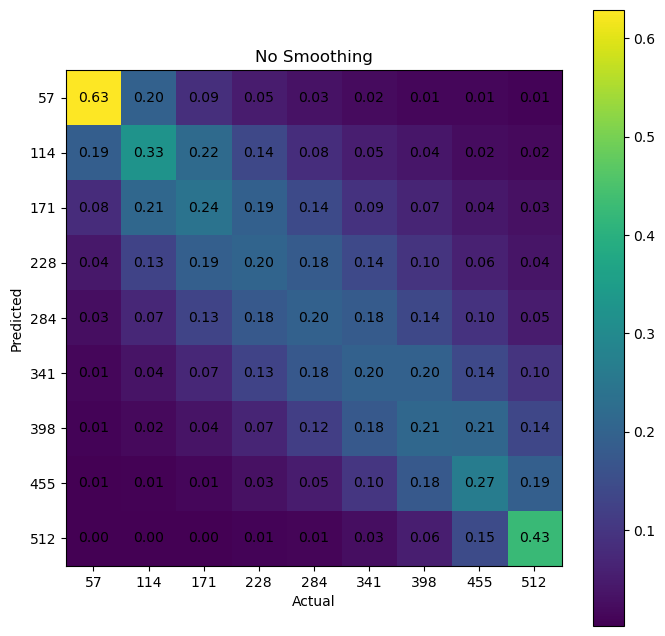

In [95]:
# plot confusion matrix with colors and numbers
confusion_matrix = conf_mat(np.argmax(Y_pred, axis=1), Y)
plot_confusion_matrix(confusion_matrix, title='No Smoothing')

1 9


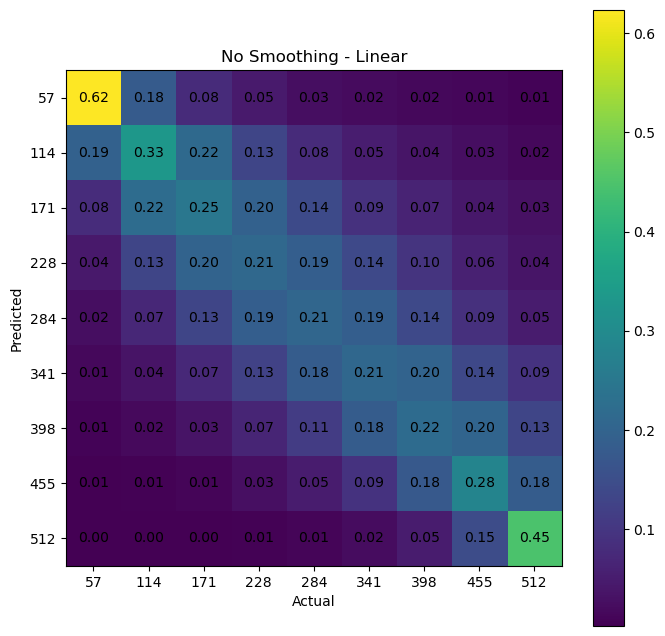

In [103]:
data = np.load('linear_0.01_0.npz')
Y_pred = data['Y_pred']
confusion_matrix = conf_mat(np.argmax(Y_pred, axis=1), Y)
plot_confusion_matrix(confusion_matrix, title='No Smoothing - Linear')

In [46]:
def smooth_probs(Y_pred, Y_test, decay_factor=0.9):
    avg_probs = None
    Y_smoothed = []
    for i in tqdm(range(len(Y_test))):
        probs = Y_pred[i]
        if avg_probs is None:
            avg_probs = probs
        else:
            avg_probs = decay_factor * avg_probs + (1 - decay_factor) * probs
        Y_smoothed.append(avg_probs)
        if Y_test[i] == 0:
            avg_probs = None
    
    return np.array(Y_smoothed)


100%|██████████| 433035/433035 [00:03<00:00, 125076.56it/s]


1 9


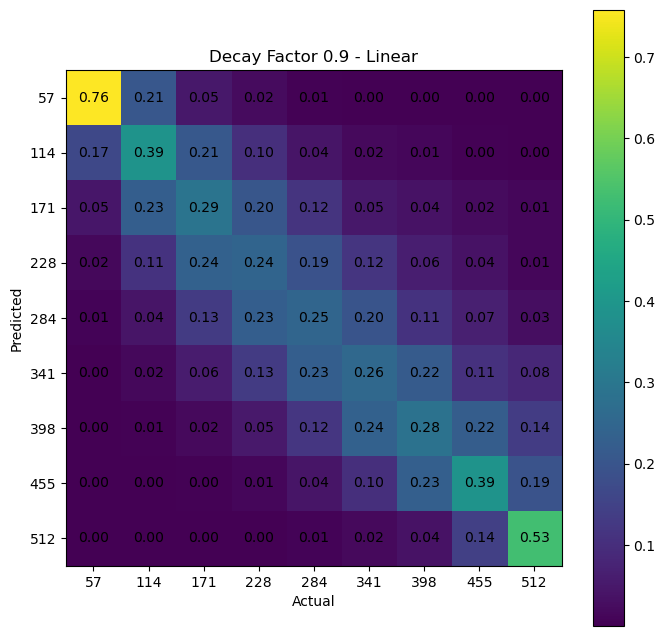

In [104]:
Y_smoothed = smooth_probs(Y_pred, Y_test, 0.9)
# plot confusion matrix with colors and numbers
confusion_matrix = conf_mat(np.argmax(Y_smoothed, axis=1), Y)
plot_confusion_matrix(confusion_matrix, title='Decay Factor 0.9 - Linear')

100%|██████████| 433035/433035 [00:03<00:00, 136893.17it/s]


1 9


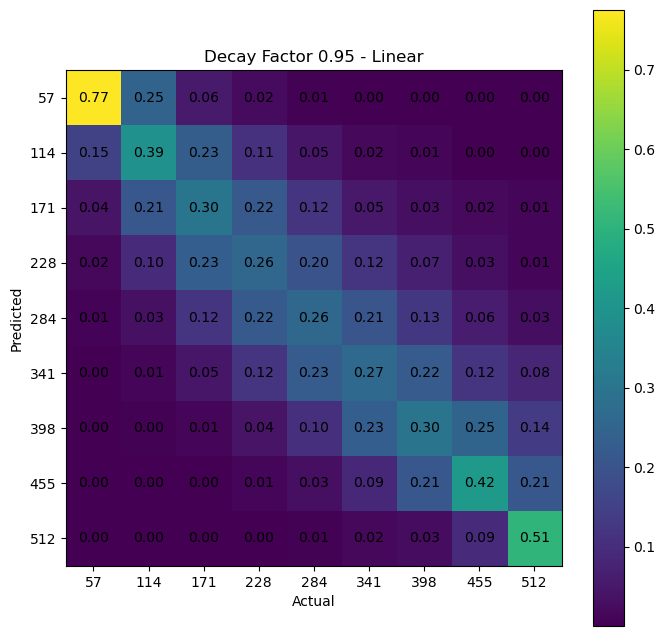

In [105]:
Y_smoothed = smooth_probs(Y_pred, Y_test, 0.95)
# plot confusion matrix with colors and numbers
confusion_matrix = conf_mat(np.argmax(Y_smoothed, axis=1), Y)
plot_confusion_matrix(confusion_matrix, title='Decay Factor 0.95 - Linear')

1 9


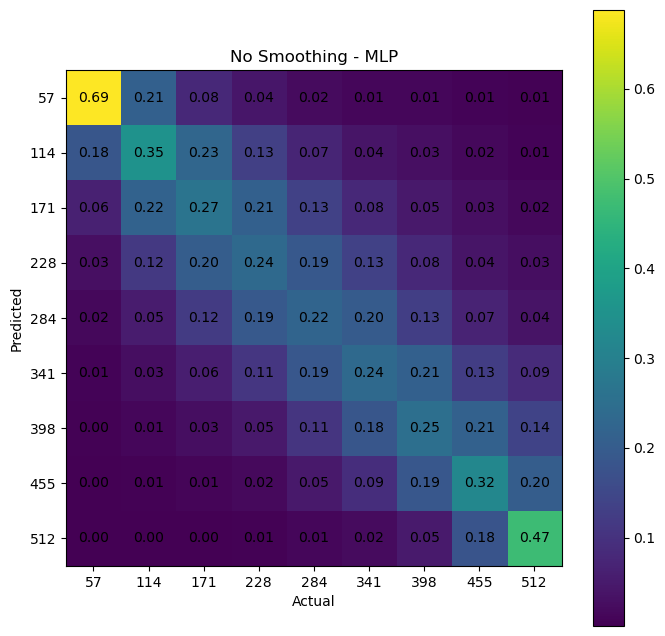

In [106]:
data = np.load('mlp64.npz')
Y_pred = data['Y_pred']
confusion_matrix = conf_mat(np.argmax(Y_pred, axis=1), Y)
plot_confusion_matrix(confusion_matrix, title='No Smoothing - MLP')

  0%|          | 0/433035 [00:00<?, ?it/s]

100%|██████████| 433035/433035 [00:03<00:00, 129422.33it/s]


1 9


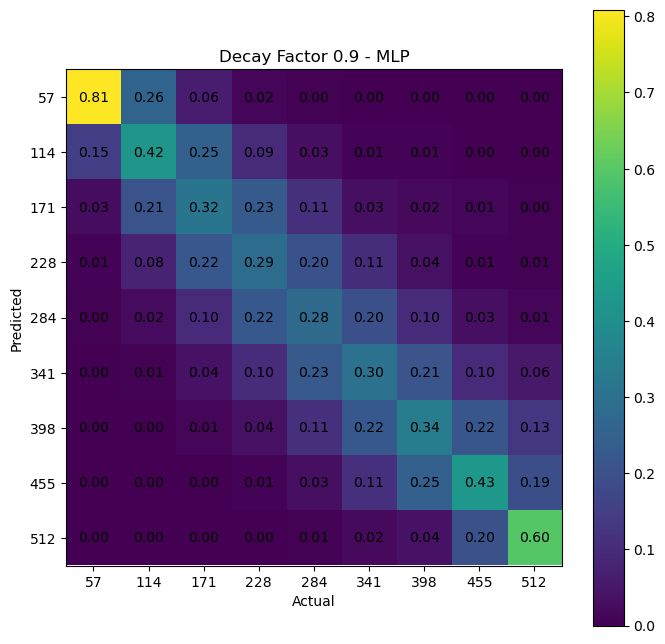

In [107]:
Y_smoothed = smooth_probs(Y_pred, Y_test, 0.9)
# plot confusion matrix with colors and numbers
confusion_matrix = conf_mat(np.argmax(Y_smoothed, axis=1), Y)
plot_confusion_matrix(confusion_matrix, title='Decay Factor 0.9 - MLP')

  0%|          | 0/433035 [00:00<?, ?it/s]

100%|██████████| 433035/433035 [00:03<00:00, 129142.88it/s]


1 9


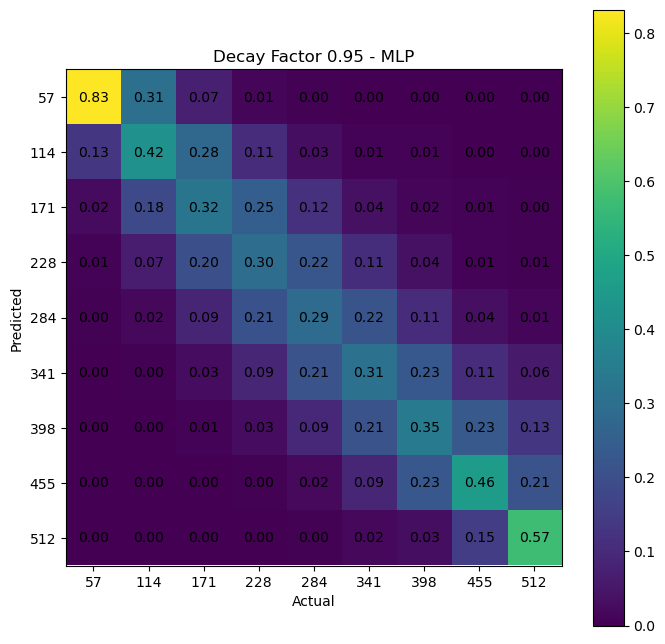

In [108]:
Y_smoothed = smooth_probs(Y_pred, Y_test, 0.95)
# plot confusion matrix with colors and numbers
confusion_matrix = conf_mat(np.argmax(Y_smoothed, axis=1), Y)
plot_confusion_matrix(confusion_matrix, title='Decay Factor 0.95 - MLP')